# Comparing Volume and Liquidity Between 3Pool and FraxBP Curve Metapools

This analysis dynamically locates all metapools for the 3pool and fraxbp on curve, then performs an analysis of their TVL (segmented by whether or not liquidity is in the base pool lp token or the paired asset) and monthly volume.

In [1]:
import json 
import os
import logging 
import asyncio
import logging

from typing import List
from datetime import timedelta
from pathlib import Path 
from pprint import PrettyPrinter

from subgrounds import Subgrounds
from web3 import Web3
from pycoingecko import CoinGeckoAPI

from prefect import task, flow 
from prefect.client import get_client
from prefect.tasks import task_input_hash

import pandas as pd 
import numpy as np 
import altair as alt 
import missingno as miss

from subgrounds.pagination import ShallowStrategy

from flywheel_util.constants import (
    colors_24,
    colors_28, 
    addresses, 
    url_infura, 
    url_snapshot, 
    url_subgraphs, 
    snapshot_api_max_records_per_request, 
    snapshot_api_max_skip,
)
from flywheel_util.tasks.general import df_to_sql
from flywheel_util.utils.util import (
    ddf, 
    first_row, 
    query_attrs,
    recursive_index_merge, 
    remove_prefix,
    df_cols_change_prefix, 
    df_cols_camel_to_snake, 
)

# logging.basicConfig(level=logging.DEBUG)

pp = PrettyPrinter().pprint

# alt.data_transformers.disable_max_rows()
alt.renderers.enable('jupyterlab')

/opt/miniconda3/envs/flywheel-testing/lib/python3.10/site-packages/eth_utils/toolz.py:2: DeprecationWarning: The toolz.compatibility module is no longer needed in Python 3 and has been deprecated. Please import these utilities directly from the standard library. This module will be removed in a future release.
  from cytoolz import (
/opt/miniconda3/envs/flywheel-testing/lib/python3.10/site-packages/web3/_utils/normalizers.py:231: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(eth_abi.__version__) < LooseVersion("2"):


RendererRegistry.enable('jupyterlab')

In [2]:
# w3 = Web3(Web3.HTTPProvider(url_infura))

In [3]:
sg = Subgrounds()
sg_curve_vol = sg.load_subgraph(url_subgraphs.convex.curve_vol_mainnet)

In [4]:
url_subgraphs.convex.curve_vol_mainnet

'https://api.thegraph.com/subgraphs/name/convex-community/volume-mainnet'

In [5]:
@task(persist_result=True, cache_key_fn=task_input_hash, cache_expiration=timedelta(days=1), tags=["curve_subgraph"])
def query_pools(metapool_lp_token: str): 
    # Get all metapools for a particular pool 
    query_pools = sg_curve_vol.Query.pools(
        first=1000, where={"coins_contains": [metapool_lp_token]}
    )
    dfs = sg.query_df([
        query_pools.id, 
        query_pools.symbol, 
        query_pools.coins, 
        query_pools.coinNames, 
    ])
    return dfs 
    
@task 
def process_pools(dfs): 
    df_pool_coin = recursive_index_merge(dfs) 
    df_pool_coin = df_cols_change_prefix(df_pool_coin, "pools_", "pool_")
    df_pool_coin = df_pool_coin.rename(columns={"pool_coins": "coin", "pool_coinNames": "coin_name"})
    return df_pool_coin

@task(persist_result=True, cache_key_fn=task_input_hash, cache_expiration=timedelta(days=1), tags=["curve_subgraph"])
def query_pool_snaps(pool_ids: List[str]): 
    query_snaps = sg_curve_vol.Query.dailyPoolSnapshots(
        first=30000, orderBy="timestamp", orderDirection="desc", where={"pool_in": pool_ids}
    )
    dfs = sg.query_df([
        query_snaps.pool.coins, 
        query_snaps.pool.id, 
        query_snaps.timestamp, 
        query_snaps.reservesUSD, 
    ], pagination_strategy=ShallowStrategy)
    return dfs 

@task 
def process_pool_snaps(dfs): 
    df_pool_snaps = recursive_index_merge(dfs) 
    df_pool_snaps = remove_prefix(df_pool_snaps, "dailyPoolSnapshots_")
    df_pool_snaps = df_cols_camel_to_snake(df_pool_snaps)
    df_pool_snaps = df_pool_snaps.rename(columns={"pool_coins": "coin"})
    df_pool_snaps.timestamp = pd.to_datetime(df_pool_snaps.timestamp, unit='s')
    return df_pool_snaps

@task(persist_result=True, cache_key_fn=task_input_hash, cache_expiration=timedelta(days=1), tags=["curve_subgraph"])
def query_pool_vol(pool_ids: List[str]): 
    query_vol = sg_curve_vol.Query.swapVolumeSnapshots(
        first=30000, orderBy="timestamp", orderDirection="desc", where={"period": 86400, "pool_in": pool_ids}
    )
    df_pool_vol = sg.query_df([
        query_vol.pool.id,
        query_vol.timestamp, 
        query_vol.volumeUSD, 
    ], pagination_strategy=ShallowStrategy)
    return df_pool_vol

@task 
def process_pool_vol(df_pool_vol): 
    df_pool_vol = remove_prefix(df_pool_vol, "swapVolumeSnapshots_")
    df_pool_vol = df_cols_camel_to_snake(df_pool_vol)
    df_pool_vol.timestamp = pd.to_datetime(df_pool_vol.timestamp, unit='s')
    return df_pool_vol
 
@flow
def flow_metapool(metapool_lp_token: str):

    dfs_pool_coin = query_pools(metapool_lp_token)  
    df_pool_coin = process_pools(dfs_pool_coin)
    
    pool_ids = df_pool_coin.pool_id.unique().tolist()
    pool_batch_size = 4
    i = 0 
    futures_snaps = []
    futures_vol = []
    while i < len(pool_ids):
        pool_id_batch = pool_ids[i:min(i+pool_batch_size, len(pool_ids))]
        i += pool_batch_size
        futures_snaps.append(query_pool_snaps.submit(pool_id_batch))
        futures_vol.append(query_pool_vol.submit(pool_id_batch))
    
    dfs_snaps = [f.result() for f in futures_snaps]
    dfs_vols = list(filter(lambda df: not df.empty, [f.result() for f in futures_vol]))
    
    dfs_snaps = list(map(lambda d: process_pool_snaps(d), dfs_snaps))
    dfs_vols = list(map(lambda d: process_pool_vol(d), dfs_vols))
            
    df_pool_snaps = pd.concat(dfs_snaps)
    df_pool_vol = pd.concat(dfs_vols)
    
    df_reserves = df_pool_coin.merge(df_pool_snaps, on=['pool_id', 'coin'])
    df_volume = df_pool_coin[['pool_id', 'pool_symbol']].drop_duplicates().merge(df_pool_vol, on=['pool_id'])

    return {"reserves": df_reserves, "volume": df_volume} 
    
@flow 
def flow_fraxbp_vs_3pool(): 
    results = {}
    for key in [
        '3crv', 
        'crvfrax'
    ]: 
        metapool_lp_token = addresses.token[key]
        results[key] = flow_metapool(metapool_lp_token)
    return results


In [6]:
async with get_client() as client:
    # set a concurrency limit of 10 on the 'small_instance' tag
    limit_id = await client.create_concurrency_limit(tag="curve_subgraph", concurrency_limit=16)

data = flow_fraxbp_vs_3pool()

14:00:21.384 | INFO    | prefect.engine - Created flow run 'lumpy-hyrax' for flow 'flow-fraxbp-vs-3pool'

/opt/miniconda3/envs/flywheel-testing/lib/python3.10/site-packages/prefect/orion/models/block_schemas.py:729: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  sa.select(


14:00:21.485 | INFO    | Flow run 'lumpy-hyrax' - Created subflow run 'ruddy-albatross' for flow 'flow-metapool'

14:00:21.516 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pools-66de95c5-0' for task 'query_pools'

14:00:21.517 | INFO    | Flow run 'ruddy-albatross' - Executing 'query_pools-66de95c5-0' immediately...

14:00:22.543 | INFO    | Task run 'query_pools-66de95c5-0' - Finished in state Completed()

14:00:22.559 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pools-45529377-0' for task 'process_pools'

14:00:22.559 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pools-45529377-0' immediately...

14:00:22.585 | INFO    | Task run 'process_pools-45529377-0' - Finished in state Completed()

14:00:22.681 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-0' for task 'query_pool_snaps'

14:00:22.682 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-0' for execution.

14:00:22.733 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-6' for task 'query_pool_snaps'

14:00:22.734 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-6' for execution.

14:00:22.794 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-18' for task 'query_pool_vol'

14:00:22.795 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-18' for execution.

14:00:22.847 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-27' for task 'query_pool_snaps'

14:00:22.849 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-27' for execution.

14:00:22.910 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-34' for task 'query_pool_vol'

14:00:22.911 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-34' for execution.

14:00:22.970 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-29' for task 'query_pool_vol'

14:00:22.971 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-29' for execution.

14:00:23.014 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-50' for task 'query_pool_snaps'

14:00:23.014 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-50' for execution.

14:00:23.028 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-62' for task 'query_pool_vol'

14:00:23.029 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-62' for execution.

14:00:23.038 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-61' for task 'query_pool_snaps'

14:00:23.039 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-61' for execution.

14:00:23.051 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-45' for task 'query_pool_snaps'

14:00:23.052 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-45' for execution.

14:00:23.074 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-60' for task 'query_pool_snaps'

14:00:23.075 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-60' for execution.

14:00:23.085 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-63' for task 'query_pool_snaps'

14:00:23.086 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-63' for execution.

14:00:23.100 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-42' for task 'query_pool_snaps'

14:00:23.101 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-42' for execution.

14:00:23.115 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-36' for task 'query_pool_vol'

14:00:23.116 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-36' for execution.

14:00:23.131 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-5' for task 'query_pool_vol'

14:00:23.132 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-5' for execution.

14:00:23.146 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-40' for task 'query_pool_vol'

14:00:23.147 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-40' for execution.

14:00:23.160 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-62' for task 'query_pool_snaps'

14:00:23.161 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-62' for execution.

14:00:23.186 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-56' for task 'query_pool_snaps'

14:00:23.187 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-56' for execution.

14:00:23.197 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-20' for task 'query_pool_snaps'

14:00:23.198 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-20' for execution.

14:00:23.209 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-35' for task 'query_pool_snaps'

14:00:23.210 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-35' for execution.

14:00:23.222 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-23' for task 'query_pool_snaps'

14:00:23.222 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-23' for execution.

14:00:23.247 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-56' for task 'query_pool_vol'

14:00:23.248 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-56' for execution.

14:00:23.256 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-59' for task 'query_pool_vol'

14:00:23.257 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-59' for execution.

14:00:23.269 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-65' for task 'query_pool_vol'

14:00:23.270 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-65' for execution.

14:00:23.280 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-30' for task 'query_pool_snaps'

14:00:23.280 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-30' for execution.

14:00:23.293 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-1' for task 'query_pool_snaps'

14:00:23.294 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-1' for execution.

14:00:23.305 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-50' for task 'query_pool_vol'

14:00:23.306 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-50' for execution.

14:00:23.317 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-4' for task 'query_pool_vol'

14:00:23.317 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-4' for execution.

14:00:23.328 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-39' for task 'query_pool_vol'

14:00:23.329 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-39' for execution.

14:00:23.339 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-55' for task 'query_pool_vol'

14:00:23.340 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-55' for execution.

14:00:23.358 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-11' for task 'query_pool_vol'

14:00:23.359 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-11' for execution.

14:00:23.374 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-65' for task 'query_pool_snaps'

14:00:23.375 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-65' for execution.

14:00:23.390 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-33' for task 'query_pool_snaps'

14:00:23.391 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-33' for execution.

14:00:23.398 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-32' for task 'query_pool_snaps'

14:00:23.399 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-32' for execution.

14:00:23.415 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-36' for task 'query_pool_snaps'

14:00:23.416 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-36' for execution.

14:00:23.424 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-9' for task 'query_pool_vol'

14:00:23.425 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-9' for execution.

14:00:23.435 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-24' for task 'query_pool_snaps'

14:00:23.436 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-24' for execution.

14:00:23.447 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-42' for task 'query_pool_vol'

14:00:23.448 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-42' for execution.

14:00:23.459 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-59' for task 'query_pool_snaps'

14:00:23.460 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-59' for execution.

14:00:23.469 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-30' for task 'query_pool_vol'

14:00:23.470 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-30' for execution.

14:00:23.485 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-47' for task 'query_pool_vol'

14:00:23.487 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-47' for execution.

14:00:23.507 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-32' for task 'query_pool_vol'

14:00:23.509 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-32' for execution.

14:00:23.530 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-37' for task 'query_pool_vol'

14:00:23.531 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-37' for execution.

14:00:23.545 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-57' for task 'query_pool_snaps'

14:00:23.546 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-57' for execution.

14:00:23.558 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-29' for task 'query_pool_snaps'

14:00:23.559 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-29' for execution.

14:00:23.574 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-46' for task 'query_pool_vol'

14:00:23.575 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-46' for execution.

14:00:23.585 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-31' for task 'query_pool_vol'

14:00:23.586 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-31' for execution.

14:00:23.597 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-17' for task 'query_pool_vol'

14:00:23.598 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-17' for execution.

14:00:23.609 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-2' for task 'query_pool_vol'

14:00:23.610 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-2' for execution.

14:00:23.623 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-53' for task 'query_pool_vol'

14:00:23.624 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-53' for execution.

14:00:23.637 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-39' for task 'query_pool_snaps'

14:00:23.638 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-39' for execution.

14:00:23.650 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-54' for task 'query_pool_vol'

14:00:23.651 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-54' for execution.

14:00:23.664 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-43' for task 'query_pool_vol'

14:00:23.665 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-43' for execution.

14:00:23.680 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-14' for task 'query_pool_snaps'

14:00:23.681 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-14' for execution.

14:00:23.698 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-18' for task 'query_pool_snaps'

14:00:23.699 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-18' for execution.

14:00:23.709 | INFO    | Task run 'query_pool_vol-8bdd8db3-62' - Finished in state Completed()

14:00:23.718 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-52' for task 'query_pool_vol'

14:00:23.718 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-52' for execution.

14:00:23.727 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-8' for task 'query_pool_snaps'

14:00:23.728 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-8' for execution.

14:00:23.740 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-23' for task 'query_pool_vol'

14:00:23.741 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-23' for execution.

14:00:23.751 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-26' for task 'query_pool_vol'

14:00:23.752 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-26' for execution.

14:00:23.777 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-13' for task 'query_pool_vol'

14:00:23.777 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-13' for execution.

14:00:23.785 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-47' for task 'query_pool_snaps'

14:00:23.786 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-47' for execution.

14:00:23.798 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-17' for task 'query_pool_snaps'

14:00:23.799 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-17' for execution.

14:00:23.814 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-51' for task 'query_pool_vol'

14:00:23.814 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-51' for execution.

14:00:23.823 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-21' for task 'query_pool_vol'

14:00:23.824 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-21' for execution.

14:00:23.835 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-10' for task 'query_pool_snaps'

14:00:23.836 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-10' for execution.

14:00:23.852 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-9' for task 'query_pool_snaps'

14:00:23.852 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-9' for execution.

14:00:23.858 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-41' for task 'query_pool_snaps'

14:00:23.858 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-41' for execution.

14:00:23.867 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-15' for task 'query_pool_snaps'

14:00:23.867 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-15' for execution.

14:00:23.882 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-15' for task 'query_pool_vol'

14:00:23.883 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-15' for execution.

14:00:23.894 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-16' for task 'query_pool_vol'

14:00:23.894 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-16' for execution.

14:00:23.905 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-48' for task 'query_pool_snaps'

14:00:23.905 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-48' for execution.

14:00:23.918 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-52' for task 'query_pool_snaps'

14:00:23.918 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-52' for execution.

14:00:23.927 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-21' for task 'query_pool_snaps'

14:00:23.928 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-21' for execution.

14:00:23.940 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-6' for task 'query_pool_vol'

14:00:23.940 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-6' for execution.

14:00:23.953 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-57' for task 'query_pool_vol'

14:00:23.954 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-57' for execution.

14:00:23.967 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-58' for task 'query_pool_vol'

14:00:23.968 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-58' for execution.

14:00:23.981 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-64' for task 'query_pool_vol'

14:00:23.982 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-64' for execution.

14:00:23.992 | INFO    | Task run 'query_pool_vol-8bdd8db3-34' - Finished in state Completed()

14:00:23.999 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-1' for task 'query_pool_vol'

14:00:23.999 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-1' for execution.

14:00:24.007 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-19' for task 'query_pool_snaps'

14:00:24.008 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-19' for execution.

14:00:24.021 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-20' for task 'query_pool_vol'

14:00:24.022 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-20' for execution.

14:00:24.032 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-7' for task 'query_pool_snaps'

14:00:24.033 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-7' for execution.

14:00:24.044 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-25' for task 'query_pool_snaps'

14:00:24.045 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-25' for execution.

14:00:24.059 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-43' for task 'query_pool_snaps'

14:00:24.062 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-43' for execution.

14:00:24.139 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-35' for task 'query_pool_vol'

14:00:24.140 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-35' for execution.

14:00:24.150 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-27' for task 'query_pool_vol'

14:00:24.151 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-27' for execution.

14:00:24.163 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-10' for task 'query_pool_vol'

14:00:24.164 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-10' for execution.

14:00:24.192 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-16' for task 'query_pool_snaps'

14:00:24.193 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-16' for execution.

14:00:24.213 | INFO    | Task run 'query_pool_vol-8bdd8db3-29' - Finished in state Completed()

14:00:24.234 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-40' for task 'query_pool_snaps'

14:00:24.234 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-40' for execution.

14:00:24.243 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-53' for task 'query_pool_snaps'

14:00:24.244 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-53' for execution.

14:00:24.255 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-38' for task 'query_pool_vol'

14:00:24.256 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-38' for execution.

14:00:24.279 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-28' for task 'query_pool_vol'

14:00:24.280 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-28' for execution.

14:00:24.295 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-46' for task 'query_pool_snaps'

14:00:24.296 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-46' for execution.

14:00:24.323 | INFO    | Task run 'query_pool_vol-8bdd8db3-1' - Finished in state Completed()

14:00:24.339 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-22' for task 'query_pool_vol'

14:00:24.340 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-22' for execution.

14:00:24.345 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-24' for task 'query_pool_vol'

14:00:24.345 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-24' for execution.

14:00:24.357 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-54' for task 'query_pool_snaps'

14:00:24.358 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-54' for execution.

14:00:24.368 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-61' for task 'query_pool_vol'

14:00:24.368 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-61' for execution.

14:00:24.380 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-12' for task 'query_pool_snaps'

14:00:24.380 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-12' for execution.

14:00:24.392 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-31' for task 'query_pool_snaps'

14:00:24.393 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-31' for execution.

14:00:24.404 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-2' for task 'query_pool_snaps'

14:00:24.405 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-2' for execution.

14:00:24.466 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-34' for task 'query_pool_snaps'

14:00:24.467 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-34' for execution.

14:00:24.476 | INFO    | Task run 'query_pool_snaps-60635b41-50' - Finished in state Completed()

14:00:24.498 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-14' for task 'query_pool_vol'

14:00:24.499 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-14' for execution.

14:00:24.511 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-49' for task 'query_pool_vol'

14:00:24.512 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-49' for execution.

14:00:24.540 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-3' for task 'query_pool_vol'

14:00:24.541 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-3' for execution.

14:00:24.550 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-19' for task 'query_pool_vol'

14:00:24.550 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-19' for execution.

14:00:24.564 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-26' for task 'query_pool_snaps'

14:00:24.565 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-26' for execution.

14:00:24.583 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-45' for task 'query_pool_vol'

14:00:24.584 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-45' for execution.

14:00:24.597 | INFO    | Task run 'query_pool_vol-8bdd8db3-18' - Finished in state Completed()

14:00:24.602 | INFO    | Task run 'query_pool_vol-8bdd8db3-20' - Finished in state Completed()

14:00:24.609 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-3' for task 'query_pool_snaps'

14:00:24.610 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-3' for execution.

14:00:24.657 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-55' for task 'query_pool_snaps'

14:00:24.658 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-55' for execution.

14:00:24.670 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-12' for task 'query_pool_vol'

14:00:24.671 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-12' for execution.

14:00:24.683 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-63' for task 'query_pool_vol'

14:00:24.684 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-63' for execution.

14:00:24.794 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-13' for task 'query_pool_snaps'

14:00:24.795 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-13' for execution.

14:00:24.809 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-33' for task 'query_pool_vol'

14:00:24.810 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-33' for execution.

14:00:24.847 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-22' for task 'query_pool_snaps'

14:00:24.848 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-22' for execution.

14:00:24.856 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-5' for task 'query_pool_snaps'

14:00:24.857 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-5' for execution.

14:00:24.868 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-38' for task 'query_pool_snaps'

14:00:24.868 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-38' for execution.

14:00:24.879 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-60' for task 'query_pool_vol'

14:00:24.880 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-60' for execution.

14:00:24.891 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-64' for task 'query_pool_snaps'

14:00:24.891 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-64' for execution.

14:00:24.966 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-0' for task 'query_pool_vol'

14:00:24.967 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-0' for execution.

14:00:24.978 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-44' for task 'query_pool_vol'

14:00:24.979 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-44' for execution.

14:00:24.987 | INFO    | Task run 'query_pool_snaps-60635b41-25' - Finished in state Completed()

14:00:25.016 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-48' for task 'query_pool_vol'

14:00:25.017 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-48' for execution.

14:00:25.053 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-51' for task 'query_pool_snaps'

14:00:25.054 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-51' for execution.

14:00:25.066 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-25' for task 'query_pool_vol'

14:00:25.067 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-25' for execution.

14:00:25.076 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-58' for task 'query_pool_snaps'

14:00:25.076 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-58' for execution.

14:00:25.091 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-28' for task 'query_pool_snaps'

14:00:25.092 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-28' for execution.

14:00:25.154 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-7' for task 'query_pool_vol'

14:00:25.155 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-7' for execution.

14:00:25.164 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-4' for task 'query_pool_snaps'

14:00:25.165 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-4' for execution.

14:00:25.175 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-41' for task 'query_pool_vol'

14:00:25.176 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-41' for execution.

14:00:25.259 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_vol-8bdd8db3-8' for task 'query_pool_vol'

14:00:25.260 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_vol-8bdd8db3-8' for execution.

14:00:25.281 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-11' for task 'query_pool_snaps'

14:00:25.282 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-11' for execution.

14:00:25.290 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-44' for task 'query_pool_snaps'

14:00:25.291 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-44' for execution.

14:00:25.482 | INFO    | Task run 'query_pool_snaps-60635b41-19' - Finished in state Completed()

14:00:25.582 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-49' for task 'query_pool_snaps'

14:00:25.583 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-49' for execution.

14:00:25.605 | INFO    | Task run 'query_pool_snaps-60635b41-7' - Finished in state Completed()

14:00:25.617 | INFO    | Task run 'query_pool_snaps-60635b41-0' - Finished in state Completed()

14:00:25.624 | INFO    | Task run 'query_pool_vol-8bdd8db3-64' - Finished in state Completed()

14:00:25.675 | INFO    | Flow run 'ruddy-albatross' - Created task run 'query_pool_snaps-60635b41-37' for task 'query_pool_snaps'

14:00:25.676 | INFO    | Flow run 'ruddy-albatross' - Submitted task run 'query_pool_snaps-60635b41-37' for execution.

14:00:26.141 | INFO    | Task run 'query_pool_snaps-60635b41-27' - Finished in state Completed()

14:00:26.560 | INFO    | Task run 'query_pool_snaps-60635b41-61' - Finished in state Completed()

14:00:26.830 | INFO    | Task run 'query_pool_snaps-60635b41-6' - Finished in state Completed()

14:00:53.499 | INFO    | Task run 'query_pool_snaps-60635b41-45' - Finished in state Completed()

14:00:54.547 | INFO    | Task run 'query_pool_vol-8bdd8db3-30' - Finished in state Completed()

14:00:55.147 | INFO    | Task run 'query_pool_vol-8bdd8db3-3' - Finished in state Completed()

14:00:55.403 | INFO    | Task run 'query_pool_vol-8bdd8db3-7' - Finished in state Completed()

14:00:57.156 | INFO    | Task run 'query_pool_snaps-60635b41-49' - Finished in state Completed()

14:01:24.067 | INFO    | Task run 'query_pool_snaps-60635b41-60' - Finished in state Completed()

14:01:25.197 | INFO    | Task run 'query_pool_snaps-60635b41-43' - Finished in state Completed()

14:01:25.435 | INFO    | Task run 'query_pool_vol-8bdd8db3-41' - Finished in state Completed()

14:01:26.633 | INFO    | Task run 'query_pool_snaps-60635b41-4' - Finished in state Completed()

14:01:26.703 | INFO    | Task run 'query_pool_snaps-60635b41-37' - Finished in state Completed()

14:01:55.226 | INFO    | Task run 'query_pool_snaps-60635b41-63' - Finished in state Completed()

14:01:57.180 | INFO    | Task run 'query_pool_snaps-60635b41-28' - Finished in state Completed()

14:02:23.947 | INFO    | Task run 'query_pool_snaps-60635b41-42' - Finished in state Completed()

14:02:24.163 | INFO    | Task run 'query_pool_vol-8bdd8db3-16' - Finished in state Completed()

14:02:25.171 | INFO    | Task run 'query_pool_snaps-60635b41-48' - Finished in state Completed()

14:02:25.423 | INFO    | Task run 'query_pool_vol-8bdd8db3-25' - Finished in state Completed()

14:02:53.402 | INFO    | Task run 'query_pool_vol-8bdd8db3-36' - Finished in state Completed()

14:02:53.728 | INFO    | Task run 'query_pool_vol-8bdd8db3-55' - Finished in state Completed()

14:02:54.149 | INFO    | Task run 'query_pool_vol-8bdd8db3-43' - Finished in state Completed()

14:02:54.554 | INFO    | Task run 'query_pool_vol-8bdd8db3-35' - Finished in state Completed()

14:02:54.800 | INFO    | Task run 'query_pool_vol-8bdd8db3-49' - Finished in state Completed()

14:02:55.099 | INFO    | Task run 'query_pool_vol-8bdd8db3-63' - Finished in state Completed()

14:02:55.334 | INFO    | Task run 'query_pool_vol-8bdd8db3-14' - Finished in state Completed()

14:02:55.715 | INFO    | Task run 'query_pool_snaps-60635b41-51' - Finished in state Completed()

14:03:23.404 | INFO    | Task run 'query_pool_vol-8bdd8db3-5' - Finished in state Completed()

14:03:23.487 | INFO    | Task run 'query_pool_vol-8bdd8db3-40' - Finished in state Completed()

14:03:23.682 | INFO    | Task run 'query_pool_vol-8bdd8db3-9' - Finished in state Completed()

14:03:24.247 | INFO    | Task run 'query_pool_vol-8bdd8db3-53' - Finished in state Completed()

14:03:25.549 | INFO    | Task run 'query_pool_snaps-60635b41-16' - Finished in state Completed()

14:03:54.260 | INFO    | Task run 'query_pool_snaps-60635b41-62' - Finished in state Completed()

14:03:55.454 | INFO    | Task run 'query_pool_snaps-60635b41-40' - Finished in state Completed()

14:04:24.342 | INFO    | Task run 'query_pool_snaps-60635b41-56' - Finished in state Completed()

14:04:24.614 | INFO    | Task run 'query_pool_vol-8bdd8db3-38' - Finished in state Completed()

14:04:25.450 | INFO    | Task run 'query_pool_snaps-60635b41-53' - Finished in state Completed()

14:04:54.854 | INFO    | Task run 'query_pool_snaps-60635b41-20' - Finished in state Completed()

14:04:56.508 | INFO    | Task run 'query_pool_snaps-60635b41-13' - Finished in state Completed()

14:05:24.484 | INFO    | Task run 'query_pool_snaps-60635b41-23' - Finished in state Completed()

14:05:24.631 | INFO    | Task run 'query_pool_snaps-60635b41-35' - Finished in state Completed()

14:05:25.263 | INFO    | Task run 'query_pool_vol-8bdd8db3-61' - Finished in state Completed()

14:05:25.687 | INFO    | Task run 'query_pool_snaps-60635b41-12' - Finished in state Completed()

14:05:26.139 | INFO    | Task run 'query_pool_snaps-60635b41-54' - Finished in state Completed()

14:05:53.596 | INFO    | Task run 'query_pool_vol-8bdd8db3-56' - Finished in state Completed()

14:05:53.875 | INFO    | Task run 'query_pool_vol-8bdd8db3-47' - Finished in state Completed()

14:05:54.800 | INFO    | Task run 'query_pool_snaps-60635b41-59' - Finished in state Completed()

14:05:55.335 | INFO    | Task run 'query_pool_snaps-60635b41-47' - Finished in state Completed()

14:05:56.274 | INFO    | Task run 'query_pool_snaps-60635b41-11' - Finished in state Completed()

14:06:23.729 | INFO    | Task run 'query_pool_vol-8bdd8db3-59' - Finished in state Completed()

14:06:24.898 | INFO    | Task run 'query_pool_snaps-60635b41-39' - Finished in state Completed()

14:06:26.003 | INFO    | Task run 'query_pool_vol-8bdd8db3-33' - Finished in state Completed()

14:06:53.812 | INFO    | Task run 'query_pool_vol-8bdd8db3-65' - Finished in state Completed()

14:06:54.063 | INFO    | Task run 'query_pool_vol-8bdd8db3-52' - Finished in state Completed()

14:06:54.354 | INFO    | Task run 'query_pool_vol-8bdd8db3-6' - Finished in state Completed()

14:06:54.659 | INFO    | Task run 'query_pool_vol-8bdd8db3-28' - Finished in state Completed()

14:06:55.288 | INFO    | Task run 'query_pool_snaps-60635b41-21' - Finished in state Completed()

14:06:55.480 | INFO    | Task run 'query_pool_snaps-60635b41-46' - Finished in state Completed()

14:06:55.767 | INFO    | Task run 'query_pool_vol-8bdd8db3-8' - Finished in state Completed()

14:06:57.570 | INFO    | Task run 'query_pool_snaps-60635b41-44' - Finished in state Completed()

14:07:23.922 | INFO    | Task run 'query_pool_vol-8bdd8db3-39' - Finished in state Completed()

14:07:24.599 | INFO    | Task run 'query_pool_vol-8bdd8db3-51' - Finished in state Completed()

14:07:24.862 | INFO    | Task run 'query_pool_vol-8bdd8db3-19' - Finished in state Completed()

14:07:25.238 | INFO    | Task run 'query_pool_vol-8bdd8db3-12' - Finished in state Completed()

14:07:26.313 | INFO    | Task run 'query_pool_snaps-60635b41-55' - Finished in state Completed()

14:07:26.530 | INFO    | Task run 'query_pool_snaps-60635b41-58' - Finished in state Completed()

14:07:53.766 | INFO    | Task run 'query_pool_vol-8bdd8db3-50' - Finished in state Completed()

14:07:54.005 | INFO    | Task run 'query_pool_vol-8bdd8db3-54' - Finished in state Completed()

14:07:55.161 | INFO    | Task run 'query_pool_snaps-60635b41-9' - Finished in state Completed()

14:07:55.497 | INFO    | Task run 'query_pool_vol-8bdd8db3-0' - Finished in state Completed()

14:07:55.607 | INFO    | Task run 'query_pool_vol-8bdd8db3-44' - Finished in state Completed()

14:07:55.666 | INFO    | Task run 'query_pool_vol-8bdd8db3-48' - Finished in state Completed()

14:07:55.802 | INFO    | Task run 'query_pool_snaps-60635b41-10' - Finished in state Completed()

14:07:56.137 | INFO    | Task run 'query_pool_snaps-60635b41-38' - Finished in state Completed()

14:07:56.144 | INFO    | Task run 'query_pool_snaps-60635b41-5' - Finished in state Completed()

14:08:24.076 | INFO    | Task run 'query_pool_vol-8bdd8db3-4' - Finished in state Completed()

14:08:24.458 | INFO    | Task run 'query_pool_vol-8bdd8db3-58' - Finished in state Completed()

14:08:24.539 | INFO    | Task run 'query_pool_snaps-60635b41-1' - Finished in state Completed()

14:08:24.784 | INFO    | Task run 'query_pool_vol-8bdd8db3-24' - Finished in state Completed()

14:08:24.835 | INFO    | Task run 'query_pool_vol-8bdd8db3-22' - Finished in state Completed()

14:08:25.593 | INFO    | Task run 'query_pool_vol-8bdd8db3-60' - Finished in state Completed()

14:08:26.869 | INFO    | Task run 'query_pool_snaps-60635b41-22' - Finished in state Completed()

14:08:27.011 | INFO    | Task run 'query_pool_snaps-60635b41-64' - Finished in state Completed()

14:08:54.151 | INFO    | Task run 'query_pool_snaps-60635b41-65' - Finished in state Completed()

14:08:54.929 | INFO    | Task run 'query_pool_snaps-60635b41-36' - Finished in state Completed()

14:09:25.229 | INFO    | Task run 'query_pool_snaps-60635b41-33' - Finished in state Completed()

14:09:53.933 | INFO    | Task run 'query_pool_vol-8bdd8db3-11' - Finished in state Completed()

14:09:54.711 | INFO    | Task run 'query_pool_snaps-60635b41-30' - Finished in state Completed()

14:09:55.378 | INFO    | Task run 'query_pool_snaps-60635b41-17' - Finished in state Completed()

14:10:24.976 | INFO    | Task run 'query_pool_snaps-60635b41-32' - Finished in state Completed()

14:10:54.850 | INFO    | Task run 'query_pool_vol-8bdd8db3-42' - Finished in state Completed()

14:11:24.410 | INFO    | Task run 'query_pool_vol-8bdd8db3-37' - Finished in state Completed()

14:11:24.771 | INFO    | Task run 'query_pool_vol-8bdd8db3-32' - Finished in state Completed()

14:11:24.948 | INFO    | Task run 'query_pool_snaps-60635b41-24' - Finished in state Completed()

14:11:25.531 | INFO    | Task run 'query_pool_snaps-60635b41-57' - Finished in state Completed()

14:11:54.375 | INFO    | Task run 'query_pool_vol-8bdd8db3-31' - Finished in state Completed()

14:11:54.392 | INFO    | Task run 'query_pool_vol-8bdd8db3-46' - Finished in state Completed()

14:11:54.511 | INFO    | Task run 'query_pool_vol-8bdd8db3-13' - Finished in state Completed()

14:11:54.525 | INFO    | Task run 'query_pool_vol-8bdd8db3-2' - Finished in state Completed()

14:11:54.530 | INFO    | Task run 'query_pool_vol-8bdd8db3-23' - Finished in state Completed()

14:11:54.535 | INFO    | Task run 'query_pool_vol-8bdd8db3-26' - Finished in state Completed()

14:11:54.659 | INFO    | Task run 'query_pool_vol-8bdd8db3-17' - Finished in state Completed()

14:11:55.332 | INFO    | Task run 'query_pool_snaps-60635b41-18' - Finished in state Completed()

14:11:55.338 | INFO    | Task run 'query_pool_snaps-60635b41-29' - Finished in state Completed()

14:11:55.496 | INFO    | Task run 'query_pool_snaps-60635b41-31' - Finished in state Completed()

14:11:55.689 | INFO    | Task run 'query_pool_snaps-60635b41-8' - Finished in state Completed()

14:11:56.363 | INFO    | Task run 'query_pool_snaps-60635b41-14' - Finished in state Completed()

14:12:24.971 | INFO    | Task run 'query_pool_vol-8bdd8db3-21' - Finished in state Completed()

14:12:25.927 | INFO    | Task run 'query_pool_snaps-60635b41-15' - Finished in state Completed()

14:12:54.966 | INFO    | Task run 'query_pool_vol-8bdd8db3-15' - Finished in state Completed()

14:12:55.021 | INFO    | Task run 'query_pool_snaps-60635b41-41' - Finished in state Completed()

14:12:55.507 | INFO    | Task run 'query_pool_snaps-60635b41-52' - Finished in state Completed()

14:13:24.585 | INFO    | Task run 'query_pool_vol-8bdd8db3-57' - Finished in state Completed()

14:13:25.933 | INFO    | Task run 'query_pool_snaps-60635b41-34' - Finished in state Completed()

14:13:54.734 | INFO    | Task run 'query_pool_vol-8bdd8db3-27' - Finished in state Completed()

14:13:54.741 | INFO    | Task run 'query_pool_vol-8bdd8db3-10' - Finished in state Completed()

14:13:55.752 | INFO    | Task run 'query_pool_snaps-60635b41-2' - Finished in state Completed()

14:14:25.959 | INFO    | Task run 'query_pool_snaps-60635b41-26' - Finished in state Completed()

14:14:55.144 | INFO    | Task run 'query_pool_vol-8bdd8db3-45' - Finished in state Completed()

14:14:56.501 | INFO    | Task run 'query_pool_snaps-60635b41-3' - Finished in state Completed()

14:14:56.526 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-0' for task 'process_pool_snaps'

14:14:56.527 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-0' immediately...

14:14:56.553 | INFO    | Task run 'process_pool_snaps-bb91f77b-0' - Finished in state Completed()

14:14:56.563 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-1' for task 'process_pool_snaps'

14:14:56.564 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-1' immediately...

14:14:56.590 | INFO    | Task run 'process_pool_snaps-bb91f77b-1' - Finished in state Completed()

14:14:56.601 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-2' for task 'process_pool_snaps'

14:14:56.602 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-2' immediately...

14:14:56.626 | INFO    | Task run 'process_pool_snaps-bb91f77b-2' - Finished in state Completed()

14:14:56.637 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-3' for task 'process_pool_snaps'

14:14:56.638 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-3' immediately...

14:14:56.662 | INFO    | Task run 'process_pool_snaps-bb91f77b-3' - Finished in state Completed()

14:14:56.673 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-4' for task 'process_pool_snaps'

14:14:56.674 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-4' immediately...

14:14:56.700 | INFO    | Task run 'process_pool_snaps-bb91f77b-4' - Finished in state Completed()

14:14:56.710 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-5' for task 'process_pool_snaps'

14:14:56.711 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-5' immediately...

14:14:56.741 | INFO    | Task run 'process_pool_snaps-bb91f77b-5' - Finished in state Completed()

14:14:56.751 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-6' for task 'process_pool_snaps'

14:14:56.752 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-6' immediately...

14:14:56.780 | INFO    | Task run 'process_pool_snaps-bb91f77b-6' - Finished in state Completed()

14:14:56.790 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-7' for task 'process_pool_snaps'

14:14:56.791 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-7' immediately...

14:14:56.816 | INFO    | Task run 'process_pool_snaps-bb91f77b-7' - Finished in state Completed()

14:14:56.826 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-8' for task 'process_pool_snaps'

14:14:56.827 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-8' immediately...

14:14:56.853 | INFO    | Task run 'process_pool_snaps-bb91f77b-8' - Finished in state Completed()

14:14:56.864 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-9' for task 'process_pool_snaps'

14:14:56.865 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-9' immediately...

14:14:56.891 | INFO    | Task run 'process_pool_snaps-bb91f77b-9' - Finished in state Completed()

14:14:56.901 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-10' for task 'process_pool_snaps'

14:14:56.902 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-10' immediately...

14:14:56.928 | INFO    | Task run 'process_pool_snaps-bb91f77b-10' - Finished in state Completed()

14:14:56.939 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-11' for task 'process_pool_snaps'

14:14:56.940 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-11' immediately...

14:14:56.966 | INFO    | Task run 'process_pool_snaps-bb91f77b-11' - Finished in state Completed()

14:14:56.979 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-12' for task 'process_pool_snaps'

14:14:56.980 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-12' immediately...

14:14:57.012 | INFO    | Task run 'process_pool_snaps-bb91f77b-12' - Finished in state Completed()

14:14:57.026 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-13' for task 'process_pool_snaps'

14:14:57.027 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-13' immediately...

14:14:57.060 | INFO    | Task run 'process_pool_snaps-bb91f77b-13' - Finished in state Completed()

14:14:57.077 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-14' for task 'process_pool_snaps'

14:14:57.078 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-14' immediately...

14:14:57.111 | INFO    | Task run 'process_pool_snaps-bb91f77b-14' - Finished in state Completed()

14:14:57.124 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-15' for task 'process_pool_snaps'

14:14:57.125 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-15' immediately...

14:14:57.153 | INFO    | Task run 'process_pool_snaps-bb91f77b-15' - Finished in state Completed()

14:14:57.164 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-16' for task 'process_pool_snaps'

14:14:57.165 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-16' immediately...

14:14:57.191 | INFO    | Task run 'process_pool_snaps-bb91f77b-16' - Finished in state Completed()

14:14:57.203 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-17' for task 'process_pool_snaps'

14:14:57.204 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-17' immediately...

14:14:57.237 | INFO    | Task run 'process_pool_snaps-bb91f77b-17' - Finished in state Completed()

14:14:57.251 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-18' for task 'process_pool_snaps'

14:14:57.252 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-18' immediately...

14:14:57.278 | INFO    | Task run 'process_pool_snaps-bb91f77b-18' - Finished in state Completed()

14:14:57.288 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-19' for task 'process_pool_snaps'

14:14:57.288 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-19' immediately...

14:14:57.313 | INFO    | Task run 'process_pool_snaps-bb91f77b-19' - Finished in state Completed()

14:14:57.324 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-20' for task 'process_pool_snaps'

14:14:57.325 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-20' immediately...

14:14:57.377 | INFO    | Task run 'process_pool_snaps-bb91f77b-20' - Finished in state Completed()

14:14:57.389 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-21' for task 'process_pool_snaps'

14:14:57.389 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-21' immediately...

14:14:57.414 | INFO    | Task run 'process_pool_snaps-bb91f77b-21' - Finished in state Completed()

14:14:57.425 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-22' for task 'process_pool_snaps'

14:14:57.426 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-22' immediately...

14:14:57.454 | INFO    | Task run 'process_pool_snaps-bb91f77b-22' - Finished in state Completed()

14:14:57.464 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-23' for task 'process_pool_snaps'

14:14:57.465 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-23' immediately...

14:14:57.492 | INFO    | Task run 'process_pool_snaps-bb91f77b-23' - Finished in state Completed()

14:14:57.502 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-24' for task 'process_pool_snaps'

14:14:57.503 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-24' immediately...

14:14:57.529 | INFO    | Task run 'process_pool_snaps-bb91f77b-24' - Finished in state Completed()

14:14:57.539 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-25' for task 'process_pool_snaps'

14:14:57.540 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-25' immediately...

14:14:57.567 | INFO    | Task run 'process_pool_snaps-bb91f77b-25' - Finished in state Completed()

14:14:57.580 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-26' for task 'process_pool_snaps'

14:14:57.581 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-26' immediately...

14:14:57.610 | INFO    | Task run 'process_pool_snaps-bb91f77b-26' - Finished in state Completed()

14:14:57.624 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-27' for task 'process_pool_snaps'

14:14:57.625 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-27' immediately...

14:14:57.655 | INFO    | Task run 'process_pool_snaps-bb91f77b-27' - Finished in state Completed()

14:14:57.668 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-28' for task 'process_pool_snaps'

14:14:57.669 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-28' immediately...

14:14:57.695 | INFO    | Task run 'process_pool_snaps-bb91f77b-28' - Finished in state Completed()

14:14:57.706 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-29' for task 'process_pool_snaps'

14:14:57.706 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-29' immediately...

14:14:57.733 | INFO    | Task run 'process_pool_snaps-bb91f77b-29' - Finished in state Completed()

14:14:57.744 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-30' for task 'process_pool_snaps'

14:14:57.745 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-30' immediately...

14:14:57.771 | INFO    | Task run 'process_pool_snaps-bb91f77b-30' - Finished in state Completed()

14:14:57.781 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-31' for task 'process_pool_snaps'

14:14:57.781 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-31' immediately...

14:14:57.805 | INFO    | Task run 'process_pool_snaps-bb91f77b-31' - Finished in state Completed()

14:14:57.816 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-32' for task 'process_pool_snaps'

14:14:57.816 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-32' immediately...

14:14:57.842 | INFO    | Task run 'process_pool_snaps-bb91f77b-32' - Finished in state Completed()

14:14:57.852 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-33' for task 'process_pool_snaps'

14:14:57.853 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-33' immediately...

14:14:57.882 | INFO    | Task run 'process_pool_snaps-bb91f77b-33' - Finished in state Completed()

14:14:57.894 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-34' for task 'process_pool_snaps'

14:14:57.895 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-34' immediately...

14:14:57.929 | INFO    | Task run 'process_pool_snaps-bb91f77b-34' - Finished in state Completed()

14:14:57.946 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-35' for task 'process_pool_snaps'

14:14:57.947 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-35' immediately...

14:14:57.976 | INFO    | Task run 'process_pool_snaps-bb91f77b-35' - Finished in state Completed()

14:14:57.987 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-36' for task 'process_pool_snaps'

14:14:57.988 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-36' immediately...

14:14:58.015 | INFO    | Task run 'process_pool_snaps-bb91f77b-36' - Finished in state Completed()

14:14:58.030 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-37' for task 'process_pool_snaps'

14:14:58.031 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-37' immediately...

14:14:58.060 | INFO    | Task run 'process_pool_snaps-bb91f77b-37' - Finished in state Completed()

14:14:58.072 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-38' for task 'process_pool_snaps'

14:14:58.073 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-38' immediately...

14:14:58.097 | INFO    | Task run 'process_pool_snaps-bb91f77b-38' - Finished in state Completed()

14:14:58.108 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-39' for task 'process_pool_snaps'

14:14:58.108 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-39' immediately...

14:14:58.133 | INFO    | Task run 'process_pool_snaps-bb91f77b-39' - Finished in state Completed()

14:14:58.144 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-40' for task 'process_pool_snaps'

14:14:58.145 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-40' immediately...

14:14:58.170 | INFO    | Task run 'process_pool_snaps-bb91f77b-40' - Finished in state Completed()

14:14:58.181 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-41' for task 'process_pool_snaps'

14:14:58.181 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-41' immediately...

14:14:58.204 | INFO    | Task run 'process_pool_snaps-bb91f77b-41' - Finished in state Completed()

14:14:58.214 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-42' for task 'process_pool_snaps'

14:14:58.214 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-42' immediately...

14:14:58.240 | INFO    | Task run 'process_pool_snaps-bb91f77b-42' - Finished in state Completed()

14:14:58.252 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-43' for task 'process_pool_snaps'

14:14:58.253 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-43' immediately...

14:14:58.290 | INFO    | Task run 'process_pool_snaps-bb91f77b-43' - Finished in state Completed()

14:14:58.305 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-44' for task 'process_pool_snaps'

14:14:58.306 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-44' immediately...

14:14:58.332 | INFO    | Task run 'process_pool_snaps-bb91f77b-44' - Finished in state Completed()

14:14:58.343 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-45' for task 'process_pool_snaps'

14:14:58.343 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-45' immediately...

14:14:58.383 | INFO    | Task run 'process_pool_snaps-bb91f77b-45' - Finished in state Completed()

14:14:58.395 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-46' for task 'process_pool_snaps'

14:14:58.396 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-46' immediately...

14:14:58.422 | INFO    | Task run 'process_pool_snaps-bb91f77b-46' - Finished in state Completed()

14:14:58.433 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-47' for task 'process_pool_snaps'

14:14:58.434 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-47' immediately...

14:14:58.463 | INFO    | Task run 'process_pool_snaps-bb91f77b-47' - Finished in state Completed()

14:14:58.473 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-48' for task 'process_pool_snaps'

14:14:58.474 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-48' immediately...

14:14:58.500 | INFO    | Task run 'process_pool_snaps-bb91f77b-48' - Finished in state Completed()

14:14:58.510 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-49' for task 'process_pool_snaps'

14:14:58.511 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-49' immediately...

14:14:58.535 | INFO    | Task run 'process_pool_snaps-bb91f77b-49' - Finished in state Completed()

14:14:58.546 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-50' for task 'process_pool_snaps'

14:14:58.546 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-50' immediately...

14:14:58.572 | INFO    | Task run 'process_pool_snaps-bb91f77b-50' - Finished in state Completed()

14:14:58.586 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-51' for task 'process_pool_snaps'

14:14:58.587 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-51' immediately...

14:14:58.615 | INFO    | Task run 'process_pool_snaps-bb91f77b-51' - Finished in state Completed()

14:14:58.626 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-52' for task 'process_pool_snaps'

14:14:58.626 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-52' immediately...

14:14:58.652 | INFO    | Task run 'process_pool_snaps-bb91f77b-52' - Finished in state Completed()

14:14:58.663 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-53' for task 'process_pool_snaps'

14:14:58.664 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-53' immediately...

14:14:58.705 | INFO    | Task run 'process_pool_snaps-bb91f77b-53' - Finished in state Completed()

14:14:58.716 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-54' for task 'process_pool_snaps'

14:14:58.716 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-54' immediately...

14:14:58.743 | INFO    | Task run 'process_pool_snaps-bb91f77b-54' - Finished in state Completed()

14:14:58.754 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-55' for task 'process_pool_snaps'

14:14:58.754 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-55' immediately...

14:14:58.779 | INFO    | Task run 'process_pool_snaps-bb91f77b-55' - Finished in state Completed()

14:14:58.790 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-56' for task 'process_pool_snaps'

14:14:58.790 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-56' immediately...

14:14:58.817 | INFO    | Task run 'process_pool_snaps-bb91f77b-56' - Finished in state Completed()

14:14:58.828 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-57' for task 'process_pool_snaps'

14:14:58.829 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-57' immediately...

14:14:58.859 | INFO    | Task run 'process_pool_snaps-bb91f77b-57' - Finished in state Completed()

14:14:58.870 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-58' for task 'process_pool_snaps'

14:14:58.871 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-58' immediately...

14:14:58.898 | INFO    | Task run 'process_pool_snaps-bb91f77b-58' - Finished in state Completed()

14:14:58.908 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-59' for task 'process_pool_snaps'

14:14:58.909 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-59' immediately...

14:14:58.936 | INFO    | Task run 'process_pool_snaps-bb91f77b-59' - Finished in state Completed()

14:14:58.948 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-60' for task 'process_pool_snaps'

14:14:58.949 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-60' immediately...

14:14:58.981 | INFO    | Task run 'process_pool_snaps-bb91f77b-60' - Finished in state Completed()

14:14:58.992 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-61' for task 'process_pool_snaps'

14:14:58.992 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-61' immediately...

14:14:59.018 | INFO    | Task run 'process_pool_snaps-bb91f77b-61' - Finished in state Completed()

14:14:59.031 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-62' for task 'process_pool_snaps'

14:14:59.032 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-62' immediately...

14:14:59.060 | INFO    | Task run 'process_pool_snaps-bb91f77b-62' - Finished in state Completed()

14:14:59.071 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-63' for task 'process_pool_snaps'

14:14:59.072 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-63' immediately...

14:14:59.098 | INFO    | Task run 'process_pool_snaps-bb91f77b-63' - Finished in state Completed()

14:14:59.109 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-64' for task 'process_pool_snaps'

14:14:59.109 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-64' immediately...

14:14:59.135 | INFO    | Task run 'process_pool_snaps-bb91f77b-64' - Finished in state Completed()

14:14:59.146 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_snaps-bb91f77b-65' for task 'process_pool_snaps'

14:14:59.147 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_snaps-bb91f77b-65' immediately...

14:14:59.177 | INFO    | Task run 'process_pool_snaps-bb91f77b-65' - Finished in state Completed()

14:14:59.188 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-0' for task 'process_pool_vol'

14:14:59.189 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-0' immediately...

14:14:59.217 | INFO    | Task run 'process_pool_vol-f3874c79-0' - Finished in state Completed()

14:14:59.230 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-1' for task 'process_pool_vol'

14:14:59.231 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-1' immediately...

14:14:59.259 | INFO    | Task run 'process_pool_vol-f3874c79-1' - Finished in state Completed()

14:14:59.269 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-2' for task 'process_pool_vol'

14:14:59.270 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-2' immediately...

14:14:59.294 | INFO    | Task run 'process_pool_vol-f3874c79-2' - Finished in state Completed()

14:14:59.308 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-3' for task 'process_pool_vol'

14:14:59.309 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-3' immediately...

14:14:59.340 | INFO    | Task run 'process_pool_vol-f3874c79-3' - Finished in state Completed()

14:14:59.352 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-4' for task 'process_pool_vol'

14:14:59.353 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-4' immediately...

14:14:59.399 | INFO    | Task run 'process_pool_vol-f3874c79-4' - Finished in state Completed()

14:14:59.413 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-5' for task 'process_pool_vol'

14:14:59.414 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-5' immediately...

14:14:59.462 | INFO    | Task run 'process_pool_vol-f3874c79-5' - Finished in state Completed()

14:14:59.477 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-6' for task 'process_pool_vol'

14:14:59.478 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-6' immediately...

14:14:59.502 | INFO    | Task run 'process_pool_vol-f3874c79-6' - Finished in state Completed()

14:14:59.513 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-7' for task 'process_pool_vol'

14:14:59.514 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-7' immediately...

14:14:59.538 | INFO    | Task run 'process_pool_vol-f3874c79-7' - Finished in state Completed()

14:14:59.550 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-8' for task 'process_pool_vol'

14:14:59.551 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-8' immediately...

14:14:59.579 | INFO    | Task run 'process_pool_vol-f3874c79-8' - Finished in state Completed()

14:14:59.591 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-9' for task 'process_pool_vol'

14:14:59.592 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-9' immediately...

14:14:59.615 | INFO    | Task run 'process_pool_vol-f3874c79-9' - Finished in state Completed()

14:14:59.625 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-10' for task 'process_pool_vol'

14:14:59.626 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-10' immediately...

14:14:59.651 | INFO    | Task run 'process_pool_vol-f3874c79-10' - Finished in state Completed()

14:14:59.662 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-11' for task 'process_pool_vol'

14:14:59.662 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-11' immediately...

14:14:59.686 | INFO    | Task run 'process_pool_vol-f3874c79-11' - Finished in state Completed()

14:14:59.700 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-12' for task 'process_pool_vol'

14:14:59.700 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-12' immediately...

14:14:59.730 | INFO    | Task run 'process_pool_vol-f3874c79-12' - Finished in state Completed()

14:14:59.741 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-13' for task 'process_pool_vol'

14:14:59.742 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-13' immediately...

14:14:59.769 | INFO    | Task run 'process_pool_vol-f3874c79-13' - Finished in state Completed()

14:14:59.780 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-14' for task 'process_pool_vol'

14:14:59.780 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-14' immediately...

14:14:59.805 | INFO    | Task run 'process_pool_vol-f3874c79-14' - Finished in state Completed()

14:14:59.815 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-15' for task 'process_pool_vol'

14:14:59.815 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-15' immediately...

14:14:59.839 | INFO    | Task run 'process_pool_vol-f3874c79-15' - Finished in state Completed()

14:14:59.849 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-16' for task 'process_pool_vol'

14:14:59.849 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-16' immediately...

14:14:59.872 | INFO    | Task run 'process_pool_vol-f3874c79-16' - Finished in state Completed()

14:14:59.881 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-17' for task 'process_pool_vol'

14:14:59.882 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-17' immediately...

14:14:59.905 | INFO    | Task run 'process_pool_vol-f3874c79-17' - Finished in state Completed()

14:14:59.914 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-18' for task 'process_pool_vol'

14:14:59.915 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-18' immediately...

14:14:59.938 | INFO    | Task run 'process_pool_vol-f3874c79-18' - Finished in state Completed()

14:14:59.948 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-19' for task 'process_pool_vol'

14:14:59.949 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-19' immediately...

14:14:59.971 | INFO    | Task run 'process_pool_vol-f3874c79-19' - Finished in state Completed()

14:14:59.980 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-20' for task 'process_pool_vol'

14:14:59.981 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-20' immediately...

14:15:00.003 | INFO    | Task run 'process_pool_vol-f3874c79-20' - Finished in state Completed()

14:15:00.013 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-21' for task 'process_pool_vol'

14:15:00.014 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-21' immediately...

14:15:00.037 | INFO    | Task run 'process_pool_vol-f3874c79-21' - Finished in state Completed()

14:15:00.047 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-22' for task 'process_pool_vol'

14:15:00.048 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-22' immediately...

14:15:00.070 | INFO    | Task run 'process_pool_vol-f3874c79-22' - Finished in state Completed()

14:15:00.080 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-23' for task 'process_pool_vol'

14:15:00.080 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-23' immediately...

14:15:00.103 | INFO    | Task run 'process_pool_vol-f3874c79-23' - Finished in state Completed()

14:15:00.112 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-24' for task 'process_pool_vol'

14:15:00.113 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-24' immediately...

14:15:00.135 | INFO    | Task run 'process_pool_vol-f3874c79-24' - Finished in state Completed()

14:15:00.145 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-25' for task 'process_pool_vol'

14:15:00.146 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-25' immediately...

14:15:00.168 | INFO    | Task run 'process_pool_vol-f3874c79-25' - Finished in state Completed()

14:15:00.178 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-26' for task 'process_pool_vol'

14:15:00.178 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-26' immediately...

14:15:00.200 | INFO    | Task run 'process_pool_vol-f3874c79-26' - Finished in state Completed()

14:15:00.210 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-27' for task 'process_pool_vol'

14:15:00.211 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-27' immediately...

14:15:00.233 | INFO    | Task run 'process_pool_vol-f3874c79-27' - Finished in state Completed()

14:15:00.242 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-28' for task 'process_pool_vol'

14:15:00.243 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-28' immediately...

14:15:00.265 | INFO    | Task run 'process_pool_vol-f3874c79-28' - Finished in state Completed()

14:15:00.276 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-29' for task 'process_pool_vol'

14:15:00.276 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-29' immediately...

14:15:00.304 | INFO    | Task run 'process_pool_vol-f3874c79-29' - Finished in state Completed()

14:15:00.314 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-30' for task 'process_pool_vol'

14:15:00.314 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-30' immediately...

14:15:00.337 | INFO    | Task run 'process_pool_vol-f3874c79-30' - Finished in state Completed()

14:15:00.347 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-31' for task 'process_pool_vol'

14:15:00.348 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-31' immediately...

14:15:00.371 | INFO    | Task run 'process_pool_vol-f3874c79-31' - Finished in state Completed()

14:15:00.380 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-32' for task 'process_pool_vol'

14:15:00.381 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-32' immediately...

14:15:00.403 | INFO    | Task run 'process_pool_vol-f3874c79-32' - Finished in state Completed()

14:15:00.415 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-33' for task 'process_pool_vol'

14:15:00.416 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-33' immediately...

14:15:00.461 | INFO    | Task run 'process_pool_vol-f3874c79-33' - Finished in state Completed()

14:15:00.472 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-34' for task 'process_pool_vol'

14:15:00.473 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-34' immediately...

14:15:00.495 | INFO    | Task run 'process_pool_vol-f3874c79-34' - Finished in state Completed()

14:15:00.505 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-35' for task 'process_pool_vol'

14:15:00.506 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-35' immediately...

14:15:00.529 | INFO    | Task run 'process_pool_vol-f3874c79-35' - Finished in state Completed()

14:15:00.539 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-36' for task 'process_pool_vol'

14:15:00.540 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-36' immediately...

14:15:00.563 | INFO    | Task run 'process_pool_vol-f3874c79-36' - Finished in state Completed()

14:15:00.572 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-37' for task 'process_pool_vol'

14:15:00.573 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-37' immediately...

14:15:00.595 | INFO    | Task run 'process_pool_vol-f3874c79-37' - Finished in state Completed()

14:15:00.604 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-38' for task 'process_pool_vol'

14:15:00.605 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-38' immediately...

14:15:00.628 | INFO    | Task run 'process_pool_vol-f3874c79-38' - Finished in state Completed()

14:15:00.637 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-39' for task 'process_pool_vol'

14:15:00.638 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-39' immediately...

14:15:00.660 | INFO    | Task run 'process_pool_vol-f3874c79-39' - Finished in state Completed()

14:15:00.670 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-40' for task 'process_pool_vol'

14:15:00.670 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-40' immediately...

14:15:00.693 | INFO    | Task run 'process_pool_vol-f3874c79-40' - Finished in state Completed()

14:15:00.702 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-41' for task 'process_pool_vol'

14:15:00.703 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-41' immediately...

14:15:00.725 | INFO    | Task run 'process_pool_vol-f3874c79-41' - Finished in state Completed()

14:15:00.735 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-42' for task 'process_pool_vol'

14:15:00.736 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-42' immediately...

14:15:00.758 | INFO    | Task run 'process_pool_vol-f3874c79-42' - Finished in state Completed()

14:15:00.768 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-43' for task 'process_pool_vol'

14:15:00.768 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-43' immediately...

14:15:00.790 | INFO    | Task run 'process_pool_vol-f3874c79-43' - Finished in state Completed()

14:15:00.800 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-44' for task 'process_pool_vol'

14:15:00.800 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-44' immediately...

14:15:00.826 | INFO    | Task run 'process_pool_vol-f3874c79-44' - Finished in state Completed()

14:15:00.837 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-45' for task 'process_pool_vol'

14:15:00.838 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-45' immediately...

14:15:00.862 | INFO    | Task run 'process_pool_vol-f3874c79-45' - Finished in state Completed()

14:15:00.875 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-46' for task 'process_pool_vol'

14:15:00.875 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-46' immediately...

14:15:00.899 | INFO    | Task run 'process_pool_vol-f3874c79-46' - Finished in state Completed()

14:15:00.909 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-47' for task 'process_pool_vol'

14:15:00.910 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-47' immediately...

14:15:00.933 | INFO    | Task run 'process_pool_vol-f3874c79-47' - Finished in state Completed()

14:15:00.945 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-48' for task 'process_pool_vol'

14:15:00.945 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-48' immediately...

14:15:00.973 | INFO    | Task run 'process_pool_vol-f3874c79-48' - Finished in state Completed()

14:15:00.985 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-49' for task 'process_pool_vol'

14:15:00.985 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-49' immediately...

14:15:01.010 | INFO    | Task run 'process_pool_vol-f3874c79-49' - Finished in state Completed()

14:15:01.021 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-50' for task 'process_pool_vol'

14:15:01.021 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-50' immediately...

14:15:01.047 | INFO    | Task run 'process_pool_vol-f3874c79-50' - Finished in state Completed()

14:15:01.057 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-51' for task 'process_pool_vol'

14:15:01.058 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-51' immediately...

14:15:01.088 | INFO    | Task run 'process_pool_vol-f3874c79-51' - Finished in state Completed()

14:15:01.100 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-52' for task 'process_pool_vol'

14:15:01.101 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-52' immediately...

14:15:01.131 | INFO    | Task run 'process_pool_vol-f3874c79-52' - Finished in state Completed()

14:15:01.142 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-53' for task 'process_pool_vol'

14:15:01.143 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-53' immediately...

14:15:01.167 | INFO    | Task run 'process_pool_vol-f3874c79-53' - Finished in state Completed()

14:15:01.178 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-54' for task 'process_pool_vol'

14:15:01.179 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-54' immediately...

14:15:01.204 | INFO    | Task run 'process_pool_vol-f3874c79-54' - Finished in state Completed()

14:15:01.214 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-55' for task 'process_pool_vol'

14:15:01.215 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-55' immediately...

14:15:01.240 | INFO    | Task run 'process_pool_vol-f3874c79-55' - Finished in state Completed()

14:15:01.250 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-56' for task 'process_pool_vol'

14:15:01.251 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-56' immediately...

14:15:01.275 | INFO    | Task run 'process_pool_vol-f3874c79-56' - Finished in state Completed()

14:15:01.285 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-57' for task 'process_pool_vol'

14:15:01.286 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-57' immediately...

14:15:01.310 | INFO    | Task run 'process_pool_vol-f3874c79-57' - Finished in state Completed()

14:15:01.320 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-58' for task 'process_pool_vol'

14:15:01.321 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-58' immediately...

14:15:01.344 | INFO    | Task run 'process_pool_vol-f3874c79-58' - Finished in state Completed()

14:15:01.354 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-59' for task 'process_pool_vol'

14:15:01.355 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-59' immediately...

14:15:01.379 | INFO    | Task run 'process_pool_vol-f3874c79-59' - Finished in state Completed()

14:15:01.389 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-60' for task 'process_pool_vol'

14:15:01.389 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-60' immediately...

14:15:01.412 | INFO    | Task run 'process_pool_vol-f3874c79-60' - Finished in state Completed()

14:15:01.422 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-61' for task 'process_pool_vol'

14:15:01.423 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-61' immediately...

14:15:01.462 | INFO    | Task run 'process_pool_vol-f3874c79-61' - Finished in state Completed()

14:15:01.492 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-62' for task 'process_pool_vol'

14:15:01.492 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-62' immediately...

14:15:01.524 | INFO    | Task run 'process_pool_vol-f3874c79-62' - Finished in state Completed()

14:15:01.534 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-63' for task 'process_pool_vol'

14:15:01.535 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-63' immediately...

14:15:01.558 | INFO    | Task run 'process_pool_vol-f3874c79-63' - Finished in state Completed()

14:15:01.567 | INFO    | Flow run 'ruddy-albatross' - Created task run 'process_pool_vol-f3874c79-64' for task 'process_pool_vol'

14:15:01.568 | INFO    | Flow run 'ruddy-albatross' - Executing 'process_pool_vol-f3874c79-64' immediately...

14:15:01.591 | INFO    | Task run 'process_pool_vol-f3874c79-64' - Finished in state Completed()

14:15:01.681 | INFO    | Flow run 'ruddy-albatross' - Finished in state Completed()

14:15:01.712 | INFO    | Flow run 'lumpy-hyrax' - Created subflow run 'elegant-poodle' for flow 'flow-metapool'

14:15:01.737 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pools-66de95c5-0' for task 'query_pools'

14:15:01.738 | INFO    | Flow run 'elegant-poodle' - Executing 'query_pools-66de95c5-0' immediately...

14:15:02.070 | INFO    | Task run 'query_pools-66de95c5-0' - Finished in state Completed()

14:15:02.090 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pools-45529377-0' for task 'process_pools'

14:15:02.091 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pools-45529377-0' immediately...

14:15:02.118 | INFO    | Task run 'process_pools-45529377-0' - Finished in state Completed()

14:15:02.197 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_snaps-60635b41-0' for task 'query_pool_snaps'

14:15:02.198 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_snaps-60635b41-0' for execution.

14:15:02.208 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_snaps-60635b41-9' for task 'query_pool_snaps'

14:15:02.209 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_snaps-60635b41-9' for execution.

14:15:02.221 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_vol-8bdd8db3-13' for task 'query_pool_vol'

14:15:02.221 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_vol-8bdd8db3-13' for execution.

14:15:02.232 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_vol-8bdd8db3-2' for task 'query_pool_vol'

14:15:02.233 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_vol-8bdd8db3-2' for execution.

14:15:02.244 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_snaps-60635b41-10' for task 'query_pool_snaps'

14:15:02.244 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_snaps-60635b41-10' for execution.

14:15:02.266 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_vol-8bdd8db3-11' for task 'query_pool_vol'

14:15:02.267 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_vol-8bdd8db3-11' for execution.

14:15:02.289 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_vol-8bdd8db3-3' for task 'query_pool_vol'

14:15:02.290 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_vol-8bdd8db3-3' for execution.

14:15:02.300 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_vol-8bdd8db3-0' for task 'query_pool_vol'

14:15:02.301 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_vol-8bdd8db3-0' for execution.

14:15:02.329 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_snaps-60635b41-8' for task 'query_pool_snaps'

14:15:02.334 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_snaps-60635b41-8' for execution.

14:15:02.369 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_snaps-60635b41-7' for task 'query_pool_snaps'

14:15:02.371 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_snaps-60635b41-7' for execution.

14:15:02.402 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_vol-8bdd8db3-9' for task 'query_pool_vol'

14:15:02.404 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_vol-8bdd8db3-9' for execution.

14:15:02.414 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_snaps-60635b41-1' for task 'query_pool_snaps'

14:15:02.415 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_snaps-60635b41-1' for execution.

14:15:02.428 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_snaps-60635b41-2' for task 'query_pool_snaps'

14:15:02.429 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_snaps-60635b41-2' for execution.

14:15:02.443 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_vol-8bdd8db3-5' for task 'query_pool_vol'

14:15:02.444 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_vol-8bdd8db3-5' for execution.

14:15:02.458 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_vol-8bdd8db3-10' for task 'query_pool_vol'

14:15:02.459 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_vol-8bdd8db3-10' for execution.

14:15:02.484 | INFO    | Task run 'query_pool_vol-8bdd8db3-13' - Finished in state Completed()

14:15:02.515 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_vol-8bdd8db3-1' for task 'query_pool_vol'

14:15:02.517 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_vol-8bdd8db3-1' for execution.

14:15:02.528 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_snaps-60635b41-3' for task 'query_pool_snaps'

14:15:02.529 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_snaps-60635b41-3' for execution.

14:15:02.542 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_snaps-60635b41-4' for task 'query_pool_snaps'

14:15:02.543 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_snaps-60635b41-4' for execution.

14:15:02.556 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_snaps-60635b41-12' for task 'query_pool_snaps'

14:15:02.557 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_snaps-60635b41-12' for execution.

14:15:02.628 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_vol-8bdd8db3-4' for task 'query_pool_vol'

14:15:02.629 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_vol-8bdd8db3-4' for execution.

14:15:02.638 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_snaps-60635b41-5' for task 'query_pool_snaps'

14:15:02.639 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_snaps-60635b41-5' for execution.

14:15:02.652 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_vol-8bdd8db3-8' for task 'query_pool_vol'

14:15:02.653 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_vol-8bdd8db3-8' for execution.

14:15:02.666 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_snaps-60635b41-13' for task 'query_pool_snaps'

14:15:02.667 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_snaps-60635b41-13' for execution.

14:15:02.699 | INFO    | Task run 'query_pool_snaps-60635b41-9' - Finished in state Completed()

14:15:02.737 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_snaps-60635b41-6' for task 'query_pool_snaps'

14:15:02.738 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_snaps-60635b41-6' for execution.

14:15:02.747 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_vol-8bdd8db3-6' for task 'query_pool_vol'

14:15:02.748 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_vol-8bdd8db3-6' for execution.

14:15:02.762 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_vol-8bdd8db3-12' for task 'query_pool_vol'

14:15:02.763 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_vol-8bdd8db3-12' for execution.

14:15:02.842 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_vol-8bdd8db3-7' for task 'query_pool_vol'

14:15:02.843 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_vol-8bdd8db3-7' for execution.

14:15:02.872 | INFO    | Flow run 'elegant-poodle' - Created task run 'query_pool_snaps-60635b41-11' for task 'query_pool_snaps'

14:15:02.873 | INFO    | Flow run 'elegant-poodle' - Submitted task run 'query_pool_snaps-60635b41-11' for execution.

14:15:02.890 | INFO    | Task run 'query_pool_vol-8bdd8db3-2' - Finished in state Completed()

14:15:02.921 | INFO    | Task run 'query_pool_snaps-60635b41-0' - Finished in state Completed()

14:15:32.853 | INFO    | Task run 'query_pool_snaps-60635b41-10' - Finished in state Completed()

14:15:33.191 | INFO    | Task run 'query_pool_vol-8bdd8db3-7' - Finished in state Completed()

14:16:02.689 | INFO    | Task run 'query_pool_vol-8bdd8db3-11' - Finished in state Completed()

14:16:03.080 | INFO    | Task run 'query_pool_vol-8bdd8db3-8' - Finished in state Completed()

14:16:32.773 | INFO    | Task run 'query_pool_vol-8bdd8db3-3' - Finished in state Completed()

14:16:33.175 | INFO    | Task run 'query_pool_snaps-60635b41-6' - Finished in state Completed()

14:17:02.688 | INFO    | Task run 'query_pool_vol-8bdd8db3-0' - Finished in state Completed()

14:17:03.138 | INFO    | Task run 'query_pool_snaps-60635b41-5' - Finished in state Completed()

14:17:32.936 | INFO    | Task run 'query_pool_snaps-60635b41-8' - Finished in state Completed()

14:18:02.979 | INFO    | Task run 'query_pool_snaps-60635b41-7' - Finished in state Completed()

14:18:32.693 | INFO    | Task run 'query_pool_vol-8bdd8db3-9' - Finished in state Completed()

14:18:33.034 | INFO    | Task run 'query_pool_vol-8bdd8db3-4' - Finished in state Completed()

14:19:03.527 | INFO    | Task run 'query_pool_snaps-60635b41-1' - Finished in state Completed()

14:19:33.096 | INFO    | Task run 'query_pool_snaps-60635b41-2' - Finished in state Completed()

14:20:03.275 | INFO    | Task run 'query_pool_vol-8bdd8db3-10' - Finished in state Completed()

14:20:03.368 | INFO    | Task run 'query_pool_vol-8bdd8db3-5' - Finished in state Completed()

14:20:33.030 | INFO    | Task run 'query_pool_vol-8bdd8db3-1' - Finished in state Completed()

14:21:03.479 | INFO    | Task run 'query_pool_snaps-60635b41-3' - Finished in state Completed()

14:21:33.672 | INFO    | Task run 'query_pool_snaps-60635b41-12' - Finished in state Completed()

14:21:33.678 | INFO    | Task run 'query_pool_snaps-60635b41-4' - Finished in state Completed()

14:22:03.339 | INFO    | Task run 'query_pool_snaps-60635b41-13' - Finished in state Completed()

14:22:33.361 | INFO    | Task run 'query_pool_vol-8bdd8db3-6' - Finished in state Completed()

14:23:03.365 | INFO    | Task run 'query_pool_vol-8bdd8db3-12' - Finished in state Completed()

14:23:03.670 | INFO    | Task run 'query_pool_snaps-60635b41-11' - Finished in state Completed()

14:23:03.683 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_snaps-bb91f77b-0' for task 'process_pool_snaps'

14:23:03.683 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_snaps-bb91f77b-0' immediately...

14:23:03.707 | INFO    | Task run 'process_pool_snaps-bb91f77b-0' - Finished in state Completed()

14:23:03.717 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_snaps-bb91f77b-1' for task 'process_pool_snaps'

14:23:03.718 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_snaps-bb91f77b-1' immediately...

14:23:03.741 | INFO    | Task run 'process_pool_snaps-bb91f77b-1' - Finished in state Completed()

14:23:03.751 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_snaps-bb91f77b-2' for task 'process_pool_snaps'

14:23:03.751 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_snaps-bb91f77b-2' immediately...

14:23:03.775 | INFO    | Task run 'process_pool_snaps-bb91f77b-2' - Finished in state Completed()

14:23:03.785 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_snaps-bb91f77b-3' for task 'process_pool_snaps'

14:23:03.785 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_snaps-bb91f77b-3' immediately...

14:23:03.808 | INFO    | Task run 'process_pool_snaps-bb91f77b-3' - Finished in state Completed()

14:23:03.818 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_snaps-bb91f77b-4' for task 'process_pool_snaps'

14:23:03.818 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_snaps-bb91f77b-4' immediately...

14:23:03.842 | INFO    | Task run 'process_pool_snaps-bb91f77b-4' - Finished in state Completed()

14:23:03.852 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_snaps-bb91f77b-5' for task 'process_pool_snaps'

14:23:03.852 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_snaps-bb91f77b-5' immediately...

14:23:03.875 | INFO    | Task run 'process_pool_snaps-bb91f77b-5' - Finished in state Completed()

14:23:03.886 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_snaps-bb91f77b-6' for task 'process_pool_snaps'

14:23:03.887 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_snaps-bb91f77b-6' immediately...

14:23:03.910 | INFO    | Task run 'process_pool_snaps-bb91f77b-6' - Finished in state Completed()

14:23:03.920 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_snaps-bb91f77b-7' for task 'process_pool_snaps'

14:23:03.921 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_snaps-bb91f77b-7' immediately...

14:23:03.944 | INFO    | Task run 'process_pool_snaps-bb91f77b-7' - Finished in state Completed()

14:23:03.954 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_snaps-bb91f77b-8' for task 'process_pool_snaps'

14:23:03.954 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_snaps-bb91f77b-8' immediately...

14:23:03.977 | INFO    | Task run 'process_pool_snaps-bb91f77b-8' - Finished in state Completed()

14:23:03.987 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_snaps-bb91f77b-9' for task 'process_pool_snaps'

14:23:03.987 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_snaps-bb91f77b-9' immediately...

14:23:04.011 | INFO    | Task run 'process_pool_snaps-bb91f77b-9' - Finished in state Completed()

14:23:04.020 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_snaps-bb91f77b-10' for task 'process_pool_snaps'

14:23:04.021 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_snaps-bb91f77b-10' immediately...

14:23:04.044 | INFO    | Task run 'process_pool_snaps-bb91f77b-10' - Finished in state Completed()

14:23:04.053 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_snaps-bb91f77b-11' for task 'process_pool_snaps'

14:23:04.054 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_snaps-bb91f77b-11' immediately...

14:23:04.077 | INFO    | Task run 'process_pool_snaps-bb91f77b-11' - Finished in state Completed()

14:23:04.087 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_snaps-bb91f77b-12' for task 'process_pool_snaps'

14:23:04.087 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_snaps-bb91f77b-12' immediately...

14:23:04.110 | INFO    | Task run 'process_pool_snaps-bb91f77b-12' - Finished in state Completed()

14:23:04.120 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_snaps-bb91f77b-13' for task 'process_pool_snaps'

14:23:04.121 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_snaps-bb91f77b-13' immediately...

14:23:04.144 | INFO    | Task run 'process_pool_snaps-bb91f77b-13' - Finished in state Completed()

14:23:04.153 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_vol-f3874c79-0' for task 'process_pool_vol'

14:23:04.154 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_vol-f3874c79-0' immediately...

14:23:04.176 | INFO    | Task run 'process_pool_vol-f3874c79-0' - Finished in state Completed()

14:23:04.186 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_vol-f3874c79-1' for task 'process_pool_vol'

14:23:04.187 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_vol-f3874c79-1' immediately...

14:23:04.209 | INFO    | Task run 'process_pool_vol-f3874c79-1' - Finished in state Completed()

14:23:04.223 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_vol-f3874c79-2' for task 'process_pool_vol'

14:23:04.224 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_vol-f3874c79-2' immediately...

14:23:04.258 | INFO    | Task run 'process_pool_vol-f3874c79-2' - Finished in state Completed()

14:23:04.269 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_vol-f3874c79-3' for task 'process_pool_vol'

14:23:04.270 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_vol-f3874c79-3' immediately...

14:23:04.293 | INFO    | Task run 'process_pool_vol-f3874c79-3' - Finished in state Completed()

14:23:04.303 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_vol-f3874c79-4' for task 'process_pool_vol'

14:23:04.304 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_vol-f3874c79-4' immediately...

14:23:04.326 | INFO    | Task run 'process_pool_vol-f3874c79-4' - Finished in state Completed()

14:23:04.336 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_vol-f3874c79-5' for task 'process_pool_vol'

14:23:04.337 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_vol-f3874c79-5' immediately...

14:23:04.359 | INFO    | Task run 'process_pool_vol-f3874c79-5' - Finished in state Completed()

14:23:04.369 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_vol-f3874c79-6' for task 'process_pool_vol'

14:23:04.369 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_vol-f3874c79-6' immediately...

14:23:04.395 | INFO    | Task run 'process_pool_vol-f3874c79-6' - Finished in state Completed()

14:23:04.407 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_vol-f3874c79-7' for task 'process_pool_vol'

14:23:04.407 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_vol-f3874c79-7' immediately...

14:23:04.433 | INFO    | Task run 'process_pool_vol-f3874c79-7' - Finished in state Completed()

14:23:04.443 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_vol-f3874c79-8' for task 'process_pool_vol'

14:23:04.443 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_vol-f3874c79-8' immediately...

14:23:04.466 | INFO    | Task run 'process_pool_vol-f3874c79-8' - Finished in state Completed()

14:23:04.476 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_vol-f3874c79-9' for task 'process_pool_vol'

14:23:04.477 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_vol-f3874c79-9' immediately...

14:23:04.500 | INFO    | Task run 'process_pool_vol-f3874c79-9' - Finished in state Completed()

14:23:04.510 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_vol-f3874c79-10' for task 'process_pool_vol'

14:23:04.510 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_vol-f3874c79-10' immediately...

14:23:04.533 | INFO    | Task run 'process_pool_vol-f3874c79-10' - Finished in state Completed()

14:23:04.543 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_vol-f3874c79-11' for task 'process_pool_vol'

14:23:04.544 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_vol-f3874c79-11' immediately...

14:23:04.567 | INFO    | Task run 'process_pool_vol-f3874c79-11' - Finished in state Completed()

14:23:04.578 | INFO    | Flow run 'elegant-poodle' - Created task run 'process_pool_vol-f3874c79-12' for task 'process_pool_vol'

14:23:04.578 | INFO    | Flow run 'elegant-poodle' - Executing 'process_pool_vol-f3874c79-12' immediately...

14:23:04.601 | INFO    | Task run 'process_pool_vol-f3874c79-12' - Finished in state Completed()

14:23:04.622 | INFO    | Flow run 'elegant-poodle' - Finished in state Completed()

14:23:04.632 | INFO    | Flow run 'lumpy-hyrax' - Finished in state Completed()

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x177f62140>


In [7]:
data_3pool = data['3crv']
df_3pool_reserves = data_3pool['reserves']
df_3pool_volume = data_3pool['volume']

data_fraxbp = data['crvfrax'] 
df_fraxbp_reserves = data_fraxbp['reserves']
df_fraxbp_volume = data_fraxbp['volume']

In [8]:
def chart_metapool_tvl(df, coin_name):
    df_mp = df.loc[df.coin_name == coin_name].groupby("timestamp")['reserves_usd'].sum().reset_index()
    df_mp['segment'] = coin_name
    df_mp_paired = df.loc[df.coin_name != coin_name].groupby("timestamp")['reserves_usd'].sum().reset_index()
    df_mp_paired['segment'] = 'paired asset'
    df_full = pd.concat([df_mp, df_mp_paired])
    return (
        alt.Chart(df_full)
        .mark_area()
        .encode(
            x="timestamp:T", 
            y="reserves_usd:Q", 
            color="segment:N", 
            tooltip=["timestamp", alt.Tooltip("reserves_usd", format="$,d"), "segment"]
        )
    )

TVL paired against crvFRAX across FraxBP metapools: $102,474,154.2540772
TVL paired against 3Crv across 3Pool metapools: $496,119,724.6308117
Ratio of paired liquidity of FraxBP to 3Pool: 20.7%


/opt/miniconda3/envs/flywheel-testing/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


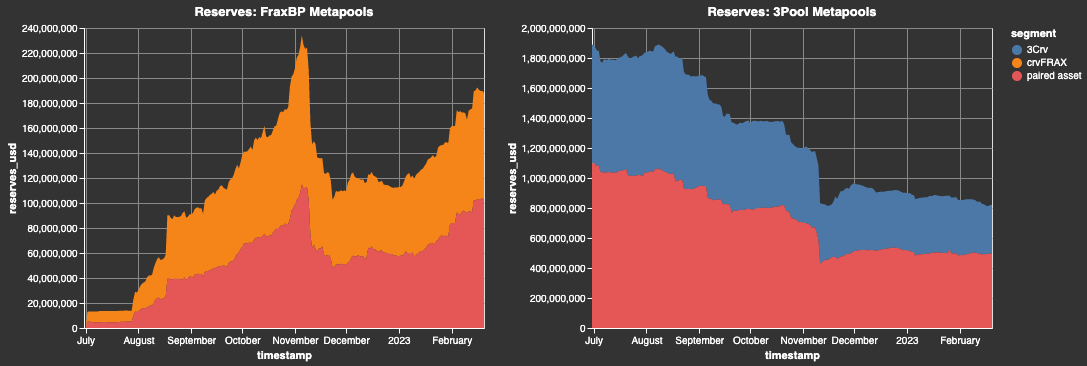

In [9]:
df_fraxbp_last = df_fraxbp_reserves.copy()
df_fraxbp_last['max_timestamp'] = df_fraxbp_last.groupby(['pool_symbol'])['timestamp'].transform("max")
df_fraxbp_last = df_fraxbp_last.loc[df_fraxbp_last.timestamp == df_fraxbp_last.max_timestamp]

df_3pool_last = df_3pool_reserves.copy()
df_3pool_last['max_timestamp'] = df_3pool_last.groupby(['pool_symbol'])['timestamp'].transform("max")
df_3pool_last = df_3pool_last.loc[df_3pool_last.timestamp == df_3pool_last.max_timestamp]

tvl_paired_fraxbp = df_fraxbp_last.loc[df_fraxbp_last.coin_name != 'crvFRAX'].reserves_usd.sum()
tvl_paired_3pool = df_3pool_last.loc[df_3pool_last.coin_name != '3Crv'].reserves_usd.sum()
print(f"TVL paired against crvFRAX across FraxBP metapools: ${tvl_paired_fraxbp:,}")
print(f"TVL paired against 3Crv across 3Pool metapools: ${tvl_paired_3pool:,}")
print(f"Ratio of paired liquidity of FraxBP to 3Pool: {100 * (tvl_paired_fraxbp / tvl_paired_3pool):.1f}%")

alt.hconcat(
    (
        chart_metapool_tvl(
            df_fraxbp_reserves, 
            'crvFRAX'
        )
        .properties(title="Reserves: FraxBP Metapools")
    ), 
    (
        chart_metapool_tvl(
            df_3pool_reserves.loc[df_3pool_reserves.timestamp >= df_fraxbp_reserves.timestamp.min()], 
            '3Crv'
        )
        .properties(title="Reserves: 3Pool Metapools")
    ),
)

In [10]:
def chart_metapool_volume(df): 
    return (
        alt.Chart(df)
        .mark_bar()
        .encode(
            x=alt.X("yearmonth(timestamp):T", axis=alt.Axis(labelAlign="center")), 
            y="volume_usd:Q", 
            tooltip=["timestamp", alt.Tooltip("volume_usd", format="$,d")]
        )
    ) 

Average volume for FraxBP metapools for month ending on 2023-02-28: $260,951.58103079614
Average volume for 3Pool metapools for month ending on 2023-02-28: $477,555.36680968176
Ratio of volume between FraxBP metapools and 3Pool metapools: 54.6%


/opt/miniconda3/envs/flywheel-testing/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


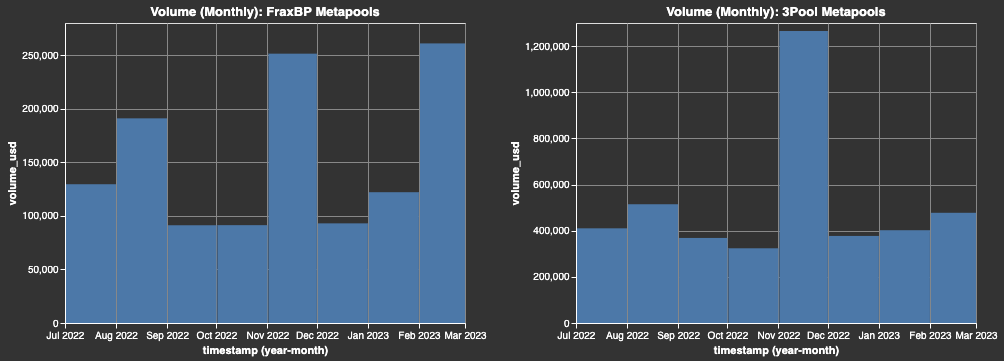

In [11]:
df_fraxbp_vol_agg = df_fraxbp_volume.groupby(pd.Grouper(key="timestamp", freq="M")).volume_usd.mean().reset_index()
df_3pool_vol_agg = df_3pool_volume.groupby(pd.Grouper(key="timestamp", freq="M")).volume_usd.mean().reset_index()
df_3pool_vol_agg = df_3pool_vol_agg.loc[df_3pool_vol_agg.timestamp >= df_fraxbp_vol_agg.timestamp.min()]

dmax = df_fraxbp_vol_agg.timestamp.max()
vol_frax = df_fraxbp_vol_agg.loc[df_fraxbp_vol_agg.timestamp == dmax].volume_usd.max()
vol_3pool = df_3pool_vol_agg.loc[df_3pool_vol_agg.timestamp == dmax].volume_usd.max()

print(f"Average volume for FraxBP metapools for month ending on {dmax.date()}: ${vol_frax:,}")
print(f"Average volume for 3Pool metapools for month ending on {dmax.date()}: ${vol_3pool:,}")
print(f"Ratio of volume between FraxBP metapools and 3Pool metapools: {100 * (vol_frax / vol_3pool):.1f}%")

(
    chart_metapool_volume(df_fraxbp_vol_agg).properties(title="Volume (Monthly): FraxBP Metapools") | 
    chart_metapool_volume(df_3pool_vol_agg).properties(title="Volume (Monthly): 3Pool Metapools")
)